In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import os
from model import detr_simplified, DETR
from cornell_dataset import CornellDataset
from view_bbox import draw_bbox

In [3]:
model = DETR(num_class=20)
loaded_model = torch.load("model_500.ckpt")

model.load_state_dict(loaded_model["model"])
model.eval()
m = 0

In [4]:
from torch.utils.data import DataLoader 
dataset_path = "dataset/cornell"
img_set = "train"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize(
                            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                            std=[1/0.229, 1/0.224, 1/0.225])
train_dataset = CornellDataset(dataset_path, "train", normalize)
val_dataset = CornellDataset(dataset_path, "val", normalize)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox).to("cpu")
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
def iou(box1,box2):
  '''
    Computes the intersection over union of two bounding boxes box = [x1,y1,x2,y2]
    where (x1, y1) and (x2, y2) are the top left and bottom right coordinates respectively
  '''
  x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
  x2, y2 = min(box1[2], box2[2]), min(box1[3], box2[3])
  inter_area = max(0, (x2 - x1 + 1)) * max(0, (y2 - y1 + 1))
  union_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1) + (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1) - inter_area
  return inter_area/union_area

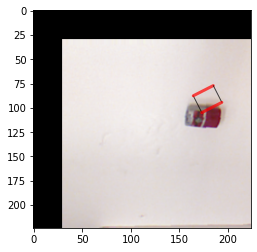

IOU: 0.08787315048536758, GT: tensor([18], dtype=torch.int32), tensor([[157.3772,  98.8023, 189.9189, 118.3273]], dtype=torch.float64) Class: 18, bboxes: tensor([[169.2877,  79.3157, 188.6981, 102.4786]])


<Figure size 432x288 with 0 Axes>

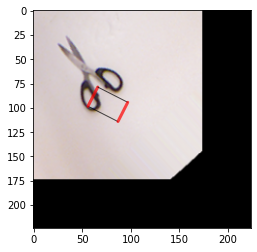

IOU: 0.0, GT: tensor([14], dtype=torch.int32), tensor([[36.1199, 63.1244, 93.9866, 83.3777]], dtype=torch.float64) Class: 14, bboxes: tensor([[ 58.9432,  85.1588,  93.6098, 107.3879]])


<Figure size 432x288 with 0 Axes>

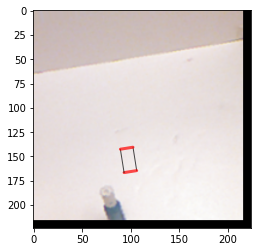

IOU: 0.0, GT: tensor([12], dtype=torch.int32), tensor([[ 55.1866, 197.0584, 111.2200, 216.0000]], dtype=torch.float64) Class: 0, bboxes: tensor([[ 85.3844, 146.9729, 109.7818, 160.1372]])


<Figure size 432x288 with 0 Axes>

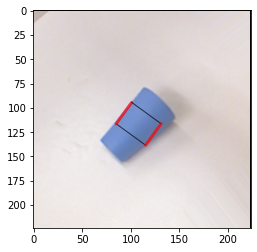

IOU: 0.1590472016992833, GT: tensor([15], dtype=torch.int32), tensor([[ 68.8333, 121.1437, 123.0575, 145.5977]], dtype=torch.float64) Class: 15, bboxes: tensor([[ 89.2634, 102.7019, 126.7016, 129.9732]])


<Figure size 432x288 with 0 Axes>

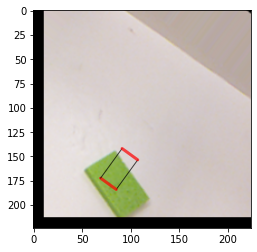

IOU: 0.03567088956343852, GT: tensor([6], dtype=torch.int32), tensor([[ 62.2980, 171.7299, 123.5793, 196.2425]], dtype=torch.float64) Class: 5, bboxes: tensor([[ 69.0746, 152.9597, 106.7633, 172.8645]])


<Figure size 432x288 with 0 Axes>

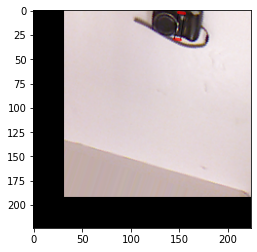

IOU: 0.16383428619140525, GT: tensor([2], dtype=torch.int32), tensor([[114.9123,   0.0000, 169.9465,  22.0336]], dtype=torch.float64) Class: 2, bboxes: tensor([[136.2671,  12.5277, 163.8388,  18.9286]])


<Figure size 432x288 with 0 Axes>

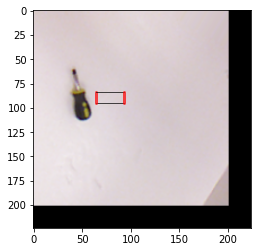

IOU: 0.010317761320643073, GT: tensor([11], dtype=torch.int32), tensor([[ 35.4754,  91.7018,  64.7131, 106.3206]], dtype=torch.float64) Class: 11, bboxes: tensor([[63.6179, 83.9258, 93.0149, 94.7565]])


<Figure size 432x288 with 0 Axes>

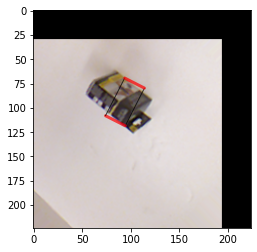

IOU: 0.18219007332486303, GT: tensor([3], dtype=torch.int32), tensor([[ 82.3632,  95.6111, 120.5547, 127.9270]], dtype=torch.float64) Class: 4, bboxes: tensor([[ 72.1259,  82.3939, 115.6933, 105.2443]])


<Figure size 432x288 with 0 Axes>

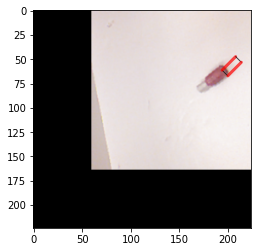

IOU: 0.06644001418741184, GT: tensor([16], dtype=torch.int32), tensor([[163.2449,  60.7551, 209.3102,  78.3437]], dtype=torch.float64) Class: 16, bboxes: tensor([[199.7311,  47.1657, 208.0136,  66.9200]])


<Figure size 432x288 with 0 Axes>

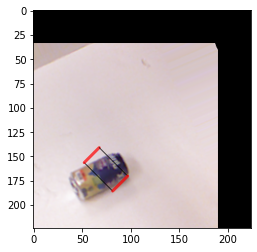

IOU: 0.17344619813091, GT: tensor([16], dtype=torch.int32), tensor([[ 32.6854, 163.6114,  82.1554, 189.3358]], dtype=torch.float64) Class: 16, bboxes: tensor([[ 53.5914, 152.3153,  95.0199, 174.2118]])
Mean IoU: 8.788195749033227, accuracy: 70.0


<Figure size 432x288 with 0 Axes>

In [6]:
device = "cpu"
model.to(device)
final_iou = 0
correct_pred = 0
for i, (x_val, y_val) in enumerate(train_loader):
    x_val = x_val.to(device)
    box = y_val
    bbox, labels = model(x_val)
    probas = labels.softmax(-1)
    probas = torch.argmax(probas, dim=2, keepdim=True)
    idx = torch.argmax(probas)
    pred_class = probas[:, idx].squeeze().cpu().numpy()

    bbox_pred = bbox[:, idx].detach().cpu() * 224

    x_val = inv_normalize(x_val)

    draw_func = draw_bbox(bbox_pred.squeeze(0).detach().cpu().numpy(), pred_class)
    draw_func.draw_rotated_box(x_val[0].permute(1, 2, 0).cpu().numpy())
    iou_calc = iou(y_val[1].squeeze(0).detach().cpu().numpy()*224, bbox_pred.squeeze(0).detach().cpu().numpy())
    final_iou += iou_calc
    if pred_class == y_val[0].numpy():
        correct_pred += 1

    print(f"IOU: {iou_calc}, GT: {y_val[0]}, {y_val[1]*224} Class: {pred_class}, bboxes: {bbox_pred}")
    i+=1
    if i == 10:
        print(f"Mean IoU: {final_iou/i * 100}, accuracy: {correct_pred/i * 100}")
        break
    